## make function and build model

We make functions to do data process, select optimizer and so on. Meanwhile, building NCF model for training and testing.

In [1]:
import random
import pandas as pd
import numpy as np
from copy import deepcopy
import tensorflow as tf
import torch
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import torch.nn as nn
from abc import ABCMeta, abstractmethod


random.seed(0)

class DataProcess(object):
    def __init__(self, filename):
        self._filename = filename
        self._loadData()
        self._preProcess()
        self._binarize(self._originalRatings)
        # 对'userId'这一列的数据，先去重，然后构成一个用户列表
        self._userPool = set(self._originalRatings['userId'].unique())
        self._itemPool = set(self._originalRatings['itemId'].unique())
        
#         print("user_pool size: ", len(self._userPool))
#         print("item_pool size: ", len(self._itemPool))

        self._select_Negatives(self._originalRatings)
        self._split_pool(self._preprocessRatings)

    def _loadData(self):
        self._originalRatings = pd.read_csv(self._filename, sep='::', header=None, names=['uid', 'mid', 'rating', 'timestamp'],
                                            engine='python')
        return self._originalRatings

    def _preProcess(self):
        """
        对user和item都重新编号，这里这么做的原因是因为，模型的输入是one-hot向量，需要把user和item都限制在Embedding的长度之内，
        模型的两个输入的长度分别是user和item的数量，所以要重新从0编号。
        """
        # 1. 新建名为"userId"的列，这列对用户从0开始编号
        user_id = self._originalRatings[['uid']].drop_duplicates().reindex()
        user_id['userId'] = np.arange(len(user_id)) #根据user的长度创建一个数组
        # 将原先的DataFrame与user_id按照"uid"这一列进行合并
        self._originalRatings = pd.merge(self._originalRatings, user_id, on=['uid'], how='left')

        # 2. 对物品进行重新排列
        item_id = self._originalRatings[['mid']].drop_duplicates()
        item_id['itemId'] = np.arange(len(item_id))
        self._originalRatings = pd.merge(self._originalRatings, item_id, on=['mid'], how='left')

        # 按照['userId', 'itemId', 'rating', 'timestamp']的顺序重新排列
        self._originalRatings = self._originalRatings[['userId', 'itemId', 'rating', 'timestamp']]
        
#         print(self._originalRatings)
        
#         print('Range of userId is [{}, {}]'.format(self._originalRatings.userId.min(), self._originalRatings.userId.max()))
#         print('Range of itemId is [{}, {}]'.format(self._originalRatings.itemId.min(), self._originalRatings.itemId.max()))

    def _binarize(self, ratings):
        """
        binarize data into 0 or 1 for implicit feedback
        """
        ratings = deepcopy(ratings)
        ratings['rating'][ratings['rating'] > 0] = 1.0
        self._preprocessRatings = ratings
        # print("binary: \n", self._preprocessRatings)

    def _select_Negatives(self, ratings):
        """
        Select al;l negative samples and 100 sampled negative items for each user.
        """
        # 构造user-item表
        interact_status = ratings.groupby('userId')['itemId'].apply(set).reset_index().rename(
            columns={'itemId': 'interacted_items'})
        
#         print("interact_status: \n", interact_status)

        # 把与用户没有产生过交互的样本都当做是负样本
        interact_status['negative_items'] = interact_status['interacted_items'].apply(lambda x: self._itemPool - x)

        # 从上面的全部负样本中随机选99个出来
        interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, 99))
        
#         print("after sampling interact_status: \n", interact_status)

#         print("select and rearrange columns")

        self._negatives = interact_status[['userId', 'negative_items', 'negative_samples']]

    def _split_pool(self, ratings):
        """leave one out train/test split """
        
#         print("sort by timestamp descend")

        # 先按照'userID'进行分组，然后根据时间戳降序排列
        ratings['rank_latest'] = ratings.groupby(['userId'])['timestamp'].rank(method='first', ascending=False)
        
#         print(ratings)

        # 选取排名第一的数据作为测试集，也就是最新的那个数据
        test = ratings[ratings['rank_latest'] == 1]
        # 选取所有排名靠后的，也就是历史数据当做训练集
        train = ratings[ratings['rank_latest'] > 1]
        # print("test: \n", test)
        # print("train: \n", train)

#         print("size of test {0}, size of train {1}".format(len(test), len(train)))

        # 确保训练集和测试集的userId是一样的
        assert train['userId'].nunique() == test['userId'].nunique()

        self.train_ratings = train[['userId', 'itemId', 'rating']]
        self.test_ratings = test[['userId', 'itemId', 'rating']]

    def sample_generator(self, num_negatives):
        # 合并之后的train_ratings的列包括['userId','itemId'，'rating','negative_items']
        train_ratings = pd.merge(self.train_ratings, self._negatives[['userId', 'negative_items']], on='userId')
        # 从用户的全部负样本集合中随机选择num_negatives个样本当做负样本，并产生一个新的名为"negatives"的列
        train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))
        
#         print(train_ratings)

        # 构造模型所需要的数据，分别是输入user、items以及目标分值ratings。
        users, items, ratings = [], [], []
        for row in train_ratings.itertuples():
            # 构造正样本，分别是userId， itemId以及目标分值1
            users.append(int(row.userId))
            items.append(int(row.itemId))
            ratings.append(float(row.rating))
            # 为每个用户构造num_negatives个负样本，分别是userId， itemId以及目标分值0
            for i in range(num_negatives):
                users.append(int(row.userId))
                items.append(int(row.negatives[i]))
                ratings.append(float(0)) # 负样本的ratings为0，直接强行设置为0

        return users, items, ratings


In [2]:
class NCF(object):
    def __init__(self, config, latent_dim_gmf=8, latent_dim_mlp=8):
        self._config = config
        self._num_users = config['num_users']
        self._num_items = config['num_items']
        self._latent_dim_gmf = latent_dim_gmf
        self._latent_dim_mlp = latent_dim_mlp

        # 建立MLP模型的user Embedding层和item Embedding层，输入的向量长度分别为用户的数量，item的数量，输出都是隐式空间的维度latent dim
        self._embedding_user_mlp = torch.nn.Embedding(num_embeddings=self._num_users, embedding_dim=self._latent_dim_mlp)
        self._embedding_item_mlp = torch.nn.Embedding(num_embeddings=self._num_users, embedding_dim=self._latent_dim_mlp)
        
        # 建立GMP模型的user Embedding层和item Embedding层，输入的向量长度分别为用户的数量，item的数量，输出都是隐式空间的维度latent dim
        self._embedding_user_gmf = torch.nn.Embedding(num_embeddings=self._num_users, embedding_dim=self._latent_dim_gmf)
        self._embedding_item_gmf = torch.nn.Embedding(num_embeddings=self._num_users, embedding_dim=self._latent_dim_gmf)

        
        # 全连接层
        self._fc_layers = torch.nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(config['layers'][:-1], config['layers'][1:])):
            self._fc_layers.append(torch.nn.Linear(in_size, out_size))

        # 激活函数
        self._logistic = nn.Sigmoid()

    @property
    def fc_layers(self):
        return self._fc_layers

    @property
    def embedding_user_gmf(self):
        return self._embedding_user_gmf

    @property
    def embedding_item_gmf(self):
        return self._embedding_item_gmf

    @property
    def embedding_user_mlp(self):
        return self._embedding_user_mlp

    @property
    def embedding_item_mlp(self):
        return self._embedding_item_mlp

    def saveModel(self):
        torch.save(self.state_dict(), self._config['model_name'])

    @abstractmethod
    def load_preTrained_weights(self):
        pass


In [3]:
class NeuMF(NCF, nn.Module):
    def __init__(self, config, latent_dim_gmf, latent_dim_mlp):
        nn.Module.__init__(self)
        NCF.__init__(self, config, latent_dim_gmf, latent_dim_mlp)

        # 创建一个线性模型，输入为GMF模型和MLP模型的潜在特征向量长度之和，输出向量长度为1
        self._affine_output = torch.nn.Linear(in_features=config['layers'][-1] + config['latent_dim_gmf'], out_features=1)

    @property
    def affine_output(self):
        return self._affine_output

    def forward(self, user_indices, item_indices):
        user_embedding_mlp = self._embedding_user_mlp(user_indices)
        item_embedding_mlp = self._embedding_item_mlp(item_indices)
        user_embedding_gmf = self._embedding_user_gmf(user_indices)
        item_embedding_gmf = self._embedding_item_gmf(item_indices)

        # concat the two latent vector
        mlp_vector = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=-1)
        # multiply the two latent vector
        gmf_vector = torch.mul(user_embedding_gmf, item_embedding_gmf)

        for idx, _ in enumerate(range(len(self._fc_layers))):
            mlp_vector = self._fc_layers[idx](mlp_vector)
            mlp_vector = torch.nn.ReLU()(mlp_vector)

        vector = torch.cat([mlp_vector, gmf_vector], dim=-1)
        logits = self._affine_output(vector)
        rating = self._logistic(logits)
        return rating

    def load_preTrained_weights(self):
        # 加载MLP模型参数
        mlp_model = MLP(self._config['mlp_config'], self._config['mlp_config']['latent_dim_mlp'])
        if self._config['use_cuda'] is True:
            mlp_model.cuda()
        state_dict = torch.load(self._config['pretrain_mlp'])
                                # map_location=lambda storage, loc: storage.cuda(device=self._config['device_id']))
                                # map_location = {'cuda:0': 'cpu'})
        mlp_model.load_state_dict(state_dict, strict=False)

        self._embedding_item_mlp.weight.data = mlp_model.embedding_item_mlp.weight.data
        self._embedding_user_mlp.weight.data = mlp_model.embedding_user_mlp.weight.data
        for idx in range(len(self._fc_layers)):
            self._fc_layers[idx].weight.data = mlp_model.fc_layers[idx].weight.data

        # 加载GMF模型参数
        gmf_model = GMF(self._config['gmf_config'], self._config['gmf_config']['latent_dim_gmf'])
        if self._config['use_cuda'] is True:
            gmf_model.cuda()
        state_dict = torch.load(self._config['pretrain_gmf'])
                                # map_location=lambda storage, loc: storage.cuda(device=self._config['device_id']))
                                # map_location = {'cuda:0': 'cpu'})
        mlp_model.load_state_dict(state_dict, strict=False)

        self._embedding_item_gmf.weight.data = gmf_model.embedding_item_gmf.weight.data
        self._embedding_user_gmf.weight.data = gmf_model.embedding_user_gmf.weight.data

        self._affine_output.weight.data = self._config['alpha'] * torch.cat([mlp_model.affine_output.weight.data, gmf_model.affine_output.weight.data], dim=-1)
        self._affine_output.bias.data = self._config['alpha'] * (mlp_model.affine_output.bias.data + gmf_model.affine_output.bias.data)

In [4]:
class Trainer(object):
    def __init__(self, model, config):
        self._config = config
        self._model = model
        # 选择优化器
        self._optimizer = pick_optimizer(self._model, self._config)
        # 定义损失函数，对于隐反馈数据，这里使用交叉熵损失函数
        self._crit = torch.nn.BCELoss()

    def _train_single_batch(self, users, items, ratings):
        """
        对单个小批量数据进行训练
        :param users: user Tensor
        :param items: item Tensor
        :param ratings: rating Tensor
        :return:
        """
        if self._config['use_cuda'] is True:
            # 将这些数据由CPU迁移到GPU
            users, items, ratings = users.cuda(), items.cuda(), ratings.cuda()

        # 先将梯度清零,如果不清零，那么这个梯度就和上一个mini-batch有关
        self._optimizer.zero_grad()
        
        # 模型的输入users， items，调用forward进行前向传播
        ratings_pred = self._model(users, items)
        
        # 通过交叉熵损失函数来计算损失, ratings_pred.view(-1)代表将预测结果摊平，变成一维的结构。
        loss = self._crit(ratings_pred.view(-1), ratings)
        
        # 反向传播计算梯度
        loss.backward()
        # 梯度下降等优化器 更新参数
        self._optimizer.step()
        # 将loss的值提取成python的float类型
        loss = loss.item()
        return loss

    def _train_an_epoch(self, train_loader, epoch_id):
        """
        训练一个Epoch，即将训练集中的所有样本全部都过一遍
        :param train_loader: Torch的DataLoader
        :param epoch_id: 训练轮次Id
        :return:
        """
        # 告诉模型目前处于训练模式，启用dropout以及batch normalization
        self._model.train()
        total_loss = 0
        best_loss = 100
        # 从DataLoader中获取小批量的id以及数据
        for batch_id, batch in enumerate(train_loader):
            assert isinstance(batch[0], torch.LongTensor)
            # 这里的user, item, rating大小变成了1024维了，因为batch_size是1024，即每次选取1024个样本数据进行训练
            user, item, rating = batch[0], batch[1], batch[2]
            rating = rating.float()
            loss = self._train_single_batch(user, item, rating)
#             print('[Training Epoch {}] Batch {}, Loss {}'.format(epoch_id, batch_id, loss))
            
            if loss < best_loss:
                best_loss = loss
                best_batch = batch_id
                
            total_loss += loss
        print("the best # of batch: {}, at this term, loss = {} \n".format(best_batch, best_loss))
        
#         print('Training Epoch: {}, TotalLoss: {} \n'.format(epoch_id, total_loss))

    def train(self, sampleGenerator):
        # 是否使用GPU加速
        self.use_cuda()
        # 是否使用预先训练好的参数
        self.load_preTrained_weights()

        for epoch in range(self._config['num_epoch']):
            
#             print('-' * 20 + ' Epoch {} starts '.format(epoch) + '-' * 20)

            # 每个轮次都重新随机产生样本数据集
            users, items, ratings = sampleGenerator(num_negatives=self._config['num_negative'])
            # 构造一个DataLoader
            data_loader = Construct_DataLoader(users=users, items=items, ratings=ratings,
                                               batchsize=self._config['batch_size'])
            # 训练一个轮次
            self._train_an_epoch(data_loader, epoch_id=epoch)

    def use_cuda(self):
        if self._config['use_cuda'] is True:
            assert torch.cuda.is_available(), 'CUDA is not available'
            torch.cuda.set_device(self._config['device_id'])
            self._model.cuda()

    def load_preTrained_weights(self):
        if self._config['pretrain'] is True:
            self._model.load_preTrained_weights()

    def save(self):
        self._model.saveModel()


In [5]:
def pick_optimizer(network, params):
    optimizer = None
    print("at this term, we choose optimizer: ", params['optimizer'])
    if params['optimizer'] == 'sgd':
        optimizer = torch.optim.SGD(network.parameters(),
                                    lr=params['sgd_lr'],
                                    momentum=params['sgd_momentum'],
                                    weight_decay=params['l2_regularization'])
    if params['optimizer'] == 'asgd':
        optimizer = torch.optim.ASGD(network.parameters(),
                                    lr=params['asgd_lr'],
                                    alpha=params['asgd_alpha'],
                                    weight_decay=params['l2_regularization'])
    elif params['optimizer'] == 'adam':
        optimizer = torch.optim.Adam(network.parameters(),
                                     lr=params['adam_lr'],
                                     weight_decay=params['l2_regularization'])
    elif params['optimizer'] == 'rmsprop':
        optimizer = torch.optim.RMSprop(network.parameters(),
                                        lr=params['rmsprop_lr'],
                                        alpha=params['rmsprop_alpha'],
                                        momentum=params['rmsprop_momentum'])
    elif params['optimizer'] == 'adamax':
        optimizer = torch.optim.Adamax(network.parameters(),
                                        lr=params['adamax_lr'],
                                        weight_decay=params['l2_regularization'])
    elif params['optimizer'] == 'adadelta':
        optimizer = torch.optim.Adadelta(network.parameters(),
                                        lr=params['adadelta_lr'],
                                        weight_decay=params['l2_regularization'])
#     elif params['optimizer'] == 'nadam':
#         optimizer = torch.optim.NAdam(network.parameters(),
#                                         lr=params['nadam_lr'],
#                                         weight_decay=params['l2_regularization'])

    return optimizer

In [6]:
class UserItemRatingDataset(Dataset):
    """
    Wrapper, convert input <user, item, rating> Tensor into torch Dataset
    """
    def __init__(self, user_tensor, item_tensor, target_tensor):
        """
        args:
            target_tensor: torch.Tensor, the corresponding rating for <user, item> pair
        """
        self._user_tensor = user_tensor
        self._item_tensor = item_tensor
        self._target_tensor = target_tensor

    def __getitem__(self, index):
        return self._user_tensor[index], self._item_tensor[index], self._target_tensor[index]

    def __len__(self):
        return self._user_tensor.size(0)

def Construct_DataLoader(users, items, ratings, batchsize):
    assert batchsize > 0
    dataset = UserItemRatingDataset(user_tensor=torch.LongTensor(users),
                                    item_tensor=torch.LongTensor(items),
                                    target_tensor=torch.LongTensor(ratings))
    return DataLoader(dataset, batch_size=batchsize, shuffle=True)

## load data and do training

In [7]:
import time

gmf_config = {'num_epoch': 1,
              'batch_size': 1024,
              
              # 'optimizer': 'sgd',
              # 'sgd_lr': 1e-3,
              # 'sgd_momentum': 0.9,
              
              # 'optimizer': 'asgd',
              # 'asgd_lr': 1e-3,
              # 'asgd_alpha': 0.99,
              
              'optimizer': 'rmsprop',
              'rmsprop_lr': 1e-3,
              'rmsprop_alpha': 0.99,
              'rmsprop_momentum': 0,
              
              # 'optimizer': 'adamax',
              # 'adamax_lr': 1e-3,
              
              # 'optimizer': 'adamdelta',
              # 'adamdelta_lr': 1e-3,
              
#               'optimizer': 'nadam',
#               'nadam_lr': 1e-3,
              
              # 'optimizer': 'adam',
              # 'adam_lr': 1e-3,
              'l2_regularization': 0, # 0.01
              
              'num_users': 6040,
              'num_items': 3706,
              'latent_dim_gmf': 8,
              'num_negative': 4,
              'layers': [],
              'pretrain': False, # do not modify this
              'use_cuda': False,
              'device_id': 2,
              'model_name': './NCF_GMF.model'
              }

mlp_config = {'num_epoch': 1,
              'batch_size': 256,  # 1024,
              
              # 'optimizer': 'sgd',
              # 'sgd_lr': 1e-3,
              # 'sgd_momentum': 0.9,

              # 'optimizer': 'asgd',
              # 'asgd_lr': 1e-3,
              # 'asgd_alpha': 0.99,              
              
              'optimizer': 'rmsprop',
              'rmsprop_lr': 1e-3,
              'rmsprop_alpha': 0.99,
              'rmsprop_momentum': 0,
              
              # 'optimizer': 'adamax',
              # 'adamax_lr': 1e-3,
              
              # 'optimizer': 'adadelta',
              # 'adamdelta_lr': 1e-3,
              
#               'optimizer': 'nadam',
#               'nadam_lr': 1e-3,
              
              # 'optimizer': 'adam',
              # 'adam_lr': 1e-3,
              'l2_regularization': 0.0000001,  # MLP model is sensitive to hyper params
              
              'num_users': 6040,
              'num_items': 3706,
              'latent_dim_mlp': 8,
              'latent_dim_gmf': 8,
              'num_negative': 4,
              'layers': [16,64,32,16,8],  # layers[0] is the concat of latent user vector & latent item vector
              'use_cuda': False,
              'device_id': 2,
              'pretrain': True,
              'gmf_config': gmf_config,
              'pretrain_gmf': './NCF_GMF.model',
              'model_name': './NCF_MLP.model'
              }

neumf_config = {'num_epoch': 1,
                'batch_size': 128, #1024
                
                # 'optimizer': 'sgd',
                # 'sgd_lr': 1e-3,
                # 'sgd_momentum': 0.9,
              
              # 'optimizer': 'asgd',
              # 'asgd_lr': 1e-3,
              # 'asgd_alpha': 0.99,                
                
               'optimizer': 'rmsprop',
               'rmsprop_lr': 1e-3,
               'rmsprop_alpha': 0.99,
               'rmsprop_momentum': 0,
               
               # 'optimizer': 'adamax',
               # 'adamax_lr': 1e-3,
              
               # 'optimizer': 'adadelta',
               # 'adadelta_lr': 1e-3,
                
#                'optimizer': 'nadam',
#                'nadam_lr': 1e-3,
                
                # 'optimizer': 'adam',
                # 'adam_lr': 1e-3,
                'l2_regularization': 0.01,
                
                'num_users': 6040,
                'num_items': 3706,
                'latent_dim_gmf': 8,
                'latent_dim_mlp': 8,
                'num_negative': 4,
                'layers': [16,32,16,8],  # layers[0] is the concat of latent user vector & latent item vector
                'alpha': 0.5, # 用于控制GMF和MLP模型参数的权重
                'use_cuda': False,
                'device_id': 2,
                'pretrain': False, # if you set this to True, you must guarantee the  Neumf layers is the same as the mlp layers
                'gmf_config': gmf_config,
                'pretrain_gmf': './NCF_GMF.model',
                'mlp_config': mlp_config,
                'pretrain_mlp': './NCF_MLP.model',
                'model_name': './NCF_NeuMF.model'
                }

if __name__ == "__main__":
    ####################################################################################
    # NCF 神经协同过滤算法
    ####################################################################################
    begin_time = time.time()   
    
    dp = DataProcess("./ratings.dat")
    
    
    # 初始化GMP模型
    # config = gmf_config
    # model = GMF(config, config['latent_dim_gmf'])

    # # 初始化MLP模型
    # config = mlp_config
    # model = MLP(config, config['latent_dim_mlp'])

    # 初始化NeuMF模型
    config = neumf_config
    model = NeuMF(config, config['latent_dim_gmf'], config['latent_dim_mlp'])

    # ###############################################################
    # 模型训练阶段
    # ###############################################################
    trainer = Trainer(model=model, config=config)
    trainer.train(dp.sample_generator)
    trainer.save()

    # ###############################################################
    # 模型测试阶段
    # ###############################################################

    # 加载数据集
    dp = DataProcess("./ratings.dat")

    config = neumf_config
    neumf = NeuMF(config, config['latent_dim_gmf'], config['latent_dim_mlp'])
    state_dict = torch.load("./NCF_NeuMF.model", map_location=torch.device('cpu'))
    neumf.load_state_dict(state_dict, strict=False)
    

#     print(neumf.forward(torch.LongTensor([1]), torch.LongTensor([1193])))
#     print(neumf.forward(torch.LongTensor([1]),torch.LongTensor([661])))
#     print(neumf.forward(torch.LongTensor([1]),torch.LongTensor([914])))
#     print(neumf.forward(torch.LongTensor([1]),torch.LongTensor([3408])))

#     print(neumf.forward(torch.LongTensor([1]),torch.LongTensor([1245])))
#     print(neumf.forward(torch.LongTensor([1]),torch.LongTensor([32])))
#     print(neumf.forward(torch.LongTensor([1]),torch.LongTensor([4])))
#     print(neumf.forward(torch.LongTensor([1]),torch.LongTensor([62])))

    print(neumf.forward(torch.IntTensor([1]), torch.IntTensor([1193])))
    print(neumf.forward(torch.IntTensor([1]),torch.IntTensor([661])))
    print(neumf.forward(torch.IntTensor([1]),torch.IntTensor([914])))
    print(neumf.forward(torch.IntTensor([1]),torch.IntTensor([3408])))

    print(neumf.forward(torch.IntTensor([1]),torch.IntTensor([1245])))
    print(neumf.forward(torch.IntTensor([1]),torch.IntTensor([32])))
    print(neumf.forward(torch.IntTensor([1]),torch.IntTensor([4])))
    print(neumf.forward(torch.IntTensor([1]),torch.IntTensor([62])))
    
#     print(neumf.forward(torch.LongTensor([1]), torch.IntTensor([1193])))
#     print(neumf.forward(torch.LongTensor([1]),torch.IntTensor([661])))
#     print(neumf.forward(torch.LongTensor([1]),torch.IntTensor([914])))
#     print(neumf.forward(torch.LongTensor([1]),torch.IntTensor([3408])))

#     print(neumf.forward(torch.LongTensor([1]),torch.IntTensor([1245])))
#     print(neumf.forward(torch.LongTensor([1]),torch.IntTensor([32])))
#     print(neumf.forward(torch.LongTensor([1]),torch.IntTensor([4])))
#     print(neumf.forward(torch.LongTensor([1]),torch.IntTensor([62])))
    
    use_time = time.time() - begin_time
    print("the using time at this is ", use_time, " seconds ")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


at this term, we choose optimizer:  rmsprop
the best # of batch: 31310, at this term, loss = 0.19889022409915924 



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


tensor([[0.0632]], grad_fn=<SigmoidBackward>)
tensor([[0.6163]], grad_fn=<SigmoidBackward>)
tensor([[0.1850]], grad_fn=<SigmoidBackward>)
tensor([[0.0044]], grad_fn=<SigmoidBackward>)
tensor([[0.1332]], grad_fn=<SigmoidBackward>)
tensor([[0.2482]], grad_fn=<SigmoidBackward>)
tensor([[0.8868]], grad_fn=<SigmoidBackward>)
tensor([[0.8839]], grad_fn=<SigmoidBackward>)
the using time at this is  210.84840273857117  seconds 


## partial results record

Partial resutls are recorded and ploted scatter. 

In [11]:
# the time record (part) for different optimizer when use LongTensor
long_time_adam = [676.56, 536.05, 612.68, 678.25, 549.54] 
long_time_adamax = [496.13, 503.63, 486.02, 603.81, 496.56] 
long_time_adadelta = [239.85, 254.93, 247.23, 240.73, 246.92]
long_time_sgd = [193.94, 198.92, 193.30, 193.42, 194.15]
long_time_asgd = [193.72, 195.04, 195.85, 195.88, 197.92]
long_time_rmsprop = [216.45, 216.86, 218.18, 217.92, 239.32]

long_time = long_time_adam
long_time.extend(long_time_adamax)
long_time.extend(long_time_adadelta)
long_time.extend(long_time_sgd)
long_time.extend(long_time_asgd)
long_time.extend(long_time_rmsprop)
avg_long_time = sum(long_time) / len(long_time)
# print("the average of time using LongTensor: ", avg_long_time)

# the time record (part) for different optimizer when use intTensor
int_time_adam = [654.27, 663.70, 559.99, 671.35, 671.74]
int_time_adamax = [495.63, 498.69,  519.06, 524.37, 532.33]
int_time_adadelta = [234.17, 233.86, 232.57, 237.85, 240.46]
int_time_sgd = [210.57, 195.53,  203.42, 217.87, 208.70]
int_time_asgd = [210.31, 201.37, 195.31, 195.78, 193.26]
int_time_rmsprop = [228.25, 224.06, 242.05, 233.82, 236.08]

int_time = int_time_adam
int_time.extend(int_time_adamax)
int_time.extend(int_time_adadelta)
int_time.extend(int_time_sgd)
int_time.extend(int_time_asgd)
int_time.extend(int_time_rmsprop)
avg_int_time = sum(int_time) / len(int_time)
# print("the average of time using intTensor: ", avg_int_time)

# the best loss record (part) for different optimizer
adam_loss = [0.3187, 0.3159, 0.2994, 0.3275, 0.3252, 0.3111, 0.3383, 0.3361, 0.3198, 0.3147]
adam_time = [676.56, 536.05, 612.68, 678.25, 549.54, 654.27, 663.70, 559.99, 671.35, 671.74]

adamax_loss = [0.3083, 0.3165, 0.3141, 0.3176, 0.3292, 0.3281, 0.3278, 0.3276, 0.3157, 0.3289]
adamax_time = [496.13, 503.63, 486.02, 603.81, 496.56, 495.63, 498.69,  519.06, 524.37, 532.33]

adadelta_loss = [0.3519, 0.3274, 0.4586, 0.4098, 0.3550, 0.3532, 0.3447, 0.3303, 0.3527, 0.3850]
adadelta_time = [234.17, 233.86, 232.57, 237.85, 240.46, 239.85, 254.93, 247.23, 240.73, 246.92]

sgd_loss = [0.3286, 0.3199, 0.3282, 0.3313, 0.3296, 0.3280, 0.3093, 0.3378, 0.3402, 0.3203]
sgd_time = [193.94, 198.92, 193.30, 193.42, 194.15, 210.57, 195.53,  203.42, 217.87, 208.70]

asgd_loss = [0.3170, 0.3358, 0.3385, 0.3410, 0.3284, 0.3379, 0.3407, 0.3384, 0.3136, 0.3181]
asgd_time = [210.31, 201.37, 195.31, 195.78, 193.26, 193.72, 195.04, 195.85, 195.88, 197.92]

rmsprop_loss = [0.1921, 0.1939, 0.1723, 0.1881, 0.1998, 0.2009, 0.1956, 0.1955, 0.2033,  0.1903]
rmsprop_time = [216.45, 216.86, 218.18, 217.92, 239.32, 228.25, 224.06, 242.05, 233.82, 236.08]

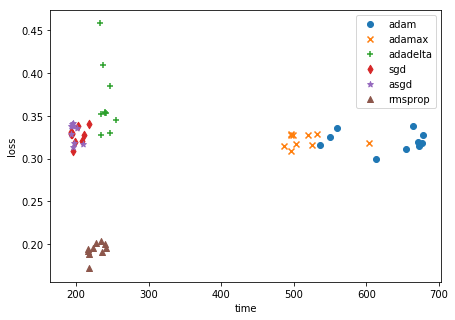

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize = (7,5))
plt.scatter(adam_time, adam_loss, marker = 'o')
plt.scatter(adamax_time, adamax_loss, marker = 'x')
plt.scatter(adadelta_time, adadelta_loss, marker = '+')
plt.scatter(sgd_time, sgd_loss, marker = 'd')
plt.scatter(asgd_time, asgd_loss, marker = '*')
plt.scatter(rmsprop_time, rmsprop_loss, marker = '^')
plt.xlabel("time")
plt.ylabel("loss")
plt.legend(["adam", "adamax", "adadelta", "sgd", "asgd", "rmsprop"])
plt.show()

# plt.savefig('optim_performance.jpg', dpi=300) #指定分辨率保存